# Warped signal modelling denoising

This notebook uses the trained AR models to predict the warped frequency components and transforms the predictions back to the time domain. AWGN noise is added to the calculated spectral coefficients.

## Load packages and functions

In [1]:
using ForneyLab       # based on last official release
using LinearAlgebra
using Plots
using PyPlot
using ProgressMeter
using Compat
using WAV
using Base64
using FileIO
using HDF5
using FLAC
using DSP
using LAR
using LAR.AR
using LAR.DataAR
using FFTW
using Distributions

include("functions/auxiliary/buffer.jl")
include("functions/auxiliary/audioplayer.jl")
include("functions/auxiliary/workflow.jl")
include("functions/auxiliary/fourier.jl")
include("functions/auxiliary/warpedfilter.jl")
;

## Adjustable parameters

In [2]:
# signal preprocessing
sound_file = "data/obama.wav"      # specify sound location
fs_desired = 16000                 # specify desired sampling frequency

# signal warping
nr_taps_warped = 32                # number of taps of warped filter bank
z_pole = 0.5756                    # pole location of all-pass filter segments (0.5756 ~ approximation Bark scale)
window = rectangularwindow         # specify windowing function from fourier.jl file

# inference and modelling
AR_order = 5                       # order of auto-regressive model
iterations = 3                     # number of iterations for variational message passing
Λ_meas = 400                       # assumed precision of measurement noise on frequency components

# load model parameters
load_file = "inferred_values/speech_AR_05.h5" # file in which model parameters are present
;

## Load data

In [3]:
# load and process speech signal
x_time, fs_time = wavread(sound_file, format="native")
fs_time = Int(fs_time)
x_time = x_time[24*fs_time+1:27*fs_time]
x_time = resample(x_time, fs_desired/fs_time)
x_time = 100*x_time/var(x_time)

# specify time axis
t = collect((1:length(x_time))/fs_desired)

# create audioplayer
audioplayers(x_time, fs=fs_desired)
;

<source src="data:audio/wav;base64,UklGRjzuAgBXQVZFZm10ICgAAAD+/wEAgD4AAAD6AAAEACAAFgAgAAAAAAADAAAAAAAQAIAAAKoAOJtxZGF0YQDuAgA0lsw8VYUwPZMyNz3bmUQ96a0nPSd4ID2fCP08wi7MPE+VpTwghG48U3oEPBpI1TkrbOu7RjmSvHBO07z3Gvu8u+MGvT8bC71vv+a8FVrbvI++srxgZYO8GggcvL1frLt5IWq786PVOhtawjsBZuk752aCO/xfhjtLFfk7f9E6PBk3Zjw/KoM8g/ZrPDithTw6RIE8x1yBPFdtiTyclo48W96FPHP1jzz8ZoM8zEVIPMmU4jttqPy6nRoyvHXdr7wGjOS8n1MAvU/sBr277w299hEavR2OF717swC9X2m4vHD5k7xL71K8bQFvu5ra1DuMO4E8Qkb7POQbLj1iUVA9PFZmPXvcgj1UDYU9Ecd8PdFPcz1lj1w9H0ZEPauyNj0kdyY9jIYdPTI7DD3jC/g8QDbePDnkzTzmisU8zc28PNpHmDzm0ks8I1awO0MLZrvofx68OtV6vCOikbwCVHq8hk15vCQCerzXvGK8aYxUvPBV/ruccS+7ZIf/OprdWjv/6pu5LUYROh4yejuY5W88p/CuPHEO7jwe+BQ9KnQuPTrYND1NjjA9exgkPeW9DT0tsdw89h+NPGAdqzua1we8yEqsvH+DAr2HEiK9HFI/vTdbVr3JlXq9PpCHvR32kL38KZO9zPyKvV6wdb1rCFe98qMzvQExFb2pqsy8PjdLvESArLuLm4s7BwlDPGjGojwLwcM8qZysPB5ChjzvxVk8ixzyO7p5zDkTc6G7d10uvCXld7wBVq+8yKfxvCzwHL3q9yC9axMeveYTF73aaAy96wvcvFG+p7yAL4S8AWhbvNAfMLzdxjW8EQSBvCQOfLyNUSu85IKBu1BGrLpJY7U5Rv92O0aZGTzx8HA873GEPNTjhTxvlp88vX61PLH9vjzFyqw88MiXPBrHgjyhfRs8qW13O4b+b7uBrEO8m3DBvGosDb3NWjG9a5c+vUy8S73LAVC91ZZKvTyGOL25KyO9Hl8DvQlup7zgvEe8Z2RFu9Fu6DsscYU8uJbHPNKOBD1Nkh89NVg6PRgaPj2LdDo9p/svPa6zGj2gWOw8HKuWPIghIDy6D307OqG1us4zsLuqkyy8PhOIvB19try/rwC9nGEfvfHEOr16JlG9iI5mvZ0Ebb2abW29bzNnvWpcYb0X5Ei9EZIavdEC4bzY7o+8aEY6vLyBtbs/fBk5bpfDOypN7ztsbz08klaFPAzLnTzCO548A7qnPFJcozyCv5k8Ot+IPJUGrzxDHrI88t3TPDWJ7jyNufs8Bu39PNVi7Txl8MU8u0eJPGmw7jtr5O664ukhvFd3mLxiB7m8kmbOvDXbyLyHxru8YniwvHsrp7zEyY68JEp1vJRyJLwNETO72z9ZO05vLjx+26Q8XLD2PEiWGz0pRTw9VyRMPS1DST0YFkM9VI44PWonHj2zJPI83l6oPBUPGzw9IJK7VLV/vFKv07xHaAm93K4bvZRAOL2lej29ONREvfUNVr2X7Vm9T0NdvVgOYr0C0G29PfhtvXP+bL29WWK9gklYvTNySr24DTW9LpIMvbat3Lyr5LG8Cw6MvE0yKrwURc27V1ebuyTJnrs4Z/m5mbQlOyrRmjvbr6w7Gu+tO5VZfDs/hY64wl6uukuxn7uOfQS828CNvOrMxbwzeuu8jy79vCpX/7z34gy9sD8cvd2ZD720eOa8BQ+svDJRCbyPxuE7jZq5PJV/Ez26FD49ao5YPRTubj2f4nk90Kl6PTwAcD0CYlY9KZ09PezgGz3CGAY9+0bkPDpiuTziYXc8yhgKPOuO2rlk5yG8/+W0vCrgAb2QCCO9v6c5vd0KQb3IiTq94zYnvWTmHL1UAgq94w7svG/tuLztTpG8ZvhUvH4RIbxaiyi8e28rvExn97tTE6K7fPgsOhnlwjuIPUo8QDKKPEexrDwqOrI8yE+/PFXnyzxENNA8pjLXPPAs6DxHG8g8OBqTPHWpFjyyHLe6K3NjvEdC4LzJlRW9a7s0vWqqRr09K1u9zb5kvQK+ab1THWO9O+4/vdCTEb3Qt7u8zHQZvNM3WzsS+IY8pqDVPNglDz1L0Cc9K307PdVZWT0yJWw9hciAPWklgT38hnE9arFZPTSwPz2BbTQ9kccePajM/Ty71rY8AWqRPNzSeTwMHFE8uMxQPBBTYTzlSUc8UHBtPH8UUjyJLz48tb8SPFVlkTsKwsI6jVmAuhzoF7tAAa66xaLHOjIfiTtqUSM859SFPMjRnTzZiqM8b36vPGv2rzwUc7k8hC3EPK6S3DwpDec8u6gFPaj2Hj3aPy49Bg85PXg3MT20JRc9pczIPKBlJzwsrsa7BSKMvIZRyLzfSve8KFMWvVM4Mb1EZD69n1ZXvbFRbr2bFnu95wVvvfX0XL1LTEm9DuM2vT6PFL1t2Ni8Kd+EvIZzzrv5B0o7cixhPGCKpzx5kLk845apPFhvjTyuIm48B2Q3PDz7BTxhI4k73UKRuknYtbvASk+8WcyavIKH2rwhthS9hXArvcTXOb1bMUO9BrhFvSd2Pb2gria9WdgPvUFQ1ryQNIi8P18XvBCemrnEs1Y7eGwUPOAfRDwg3zI8vuwbPLDTAjye7Nc7asz5Ow6s4juf8vI7tuj3O8U4mzve7E87h7uiOutPz7rRUZC73oYEvM9RTrxtq8G8ag0AvTtfHb2wVj69ey5Qvfb5Xr1aD2u9Fl9wvaw4bb2EG2O97hVQvfEoOb1cKhe9O37gvE7HhrwKlXq7RnLKO+/tXTyxQb08f8gMPUb+OT34tGM9eNtxPfZjcj0NyV09R+E1PZFRET2ujro8XU9cPA6tBDxnN1E7wdWbuqUHlLvzCQm8SERYvCJXkrzlXqC8VHuwvN1kuby7u7e8G1XAvNIP1rwCIe+8ZSX9vBGqAb3/LO+8VU3ZvHJnmbyrKXC8Y10tvOqItLvcX+U6l6YNPC1GWTzUPok8yDyZPA0zrTy7hMU8J+7SPAQp0Dzfydw8FDrlPEsw8TxKQ/U80ZfhPCR7sDwqmXU8pyYhPId8AzzV3wI84pHQO/UQlzoCtoi73aTju8Ld47sj9/G7Pm71u5rOo7uvohK73IJaO73QJzy+foY8MgmyPDD73DzCJAw9XNoePSBpJD1cfR49bjoePQQ/GT0/qBw9Cr4ePTpoHT23rws9XsT+PO5u0zwvgJE8vQgIPMfdJ7vnCUW8nG+TvBMKqbwhNMi8YYLkvGbP9LzgDQG91zgDvYt1E724hSO9ua4uvXuPN71HBzW9CHo1vSUPOL11TC299eMcvQXQDr3qUAC9z1PxvM0X4bx9V8a8kh6evEgfSrzXJhG8z8k4u4wvAzuYWYQ7IFh7Oxm31rla3va7Het9vPfZy7x16wi9cGEivQH9Qb2CQWG9UYpsvbMscL0MDmi9EKZdvUyoQb1f2x29DPcKvQZ7xbyLcne8wYm3u34PwDuhznE8J0u+PP9HDD0CTCY9SA4+PZEUQD2WBzE9NeolPcRaCD1ha9s8oECGPDGiEDyI7OQ7kUTIOlC0hbtT1C2894KvvHi08LzxZA+9omoZvaUeCr0gPAO9t+kDvVAu7LzsqNa8s5quvMwAp7yWhpe8ujlKvIB6C7wiEZW7wI4dOjNfYTuZIa071KjmO9WnKjx0CV48IcqNPEO9szzNab48Zj7UPAVa1zy2etg8qVfePO+Z0TyQpNI8Pka9PPBDqzw8oG08Qw8APJ0ziTrFeDO8earBvC3HCb0t+TG9NzpSvRLqab1Cx229F7RuvTJmar2Uxk29JQEzvZk8Er3Y0Nu8ww2JvP0uFbwkubg67EMlPIIaqTzWCwI9m/QbPQJWHz37Dx09/9ANPeEw6zyMhK88z1hkPNNuHzwCfgI7J/+AuhDst7uat

## Visualize data

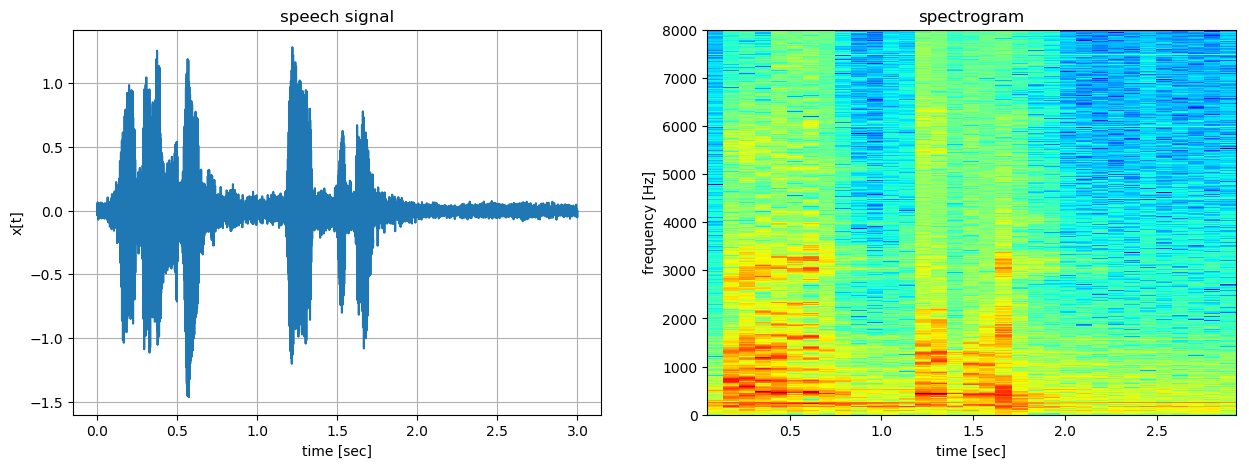

In [4]:
# create figure with subplots
_, ax = plt.subplots(ncols=2, figsize=(15,5))

# plot speech signal as a function of time
ax[1].plot(t, x_time)

# plot spectrogram of speech signal
plot_spectrogram(spectrogram(x_time, convert(Int, 100e-3*fs_desired), convert(Int, 10e-3*fs_desired), fs=fs_desired), fs_desired, ax=ax[2])

# visual modifications
ax[1].grid(), ax[1].set_ylabel("x[t]"), ax[1].set_xlabel("time [sec]"), ax[1].set_title("speech signal"), ax[2].set_title("spectrogram")
;

## Warp signal and calculate warped frequency distribution

In [5]:
# initialize memory vector of taps, Y, with zeros
Y = zeros(nr_taps_warped*3,1)

# initialize memory struct for filter taps and spectrum coefficients
mem_taps = Array{Array{Float64,1}}(undef, length(x_time))
mem_spec = Array{Complex{Float64},2}(undef, length(x_time), nr_taps_warped)

# get update matrices as defined in thesis
W, U = allpass_update_matrix(nr_taps_warped, z_pole)

# loopt through time-domain signal
for k = 1:length(x_time)
    
    # update memory vector of taps and taps themselves
    Y, mem_taps[k] = allpass_update(x_time[k], Y, nr_taps_warped, z_pole, T=W, u=U)

    # calculate windowed FFT of taps
    mem_spec[k,:] = FFTW.fft(window(nr_taps_warped).*mem_taps[k])
    
end

# discard frequency components concerning non-positive frequencies (are complex conjugate, because of real temporal signal)
if nr_taps_warped%2 == 0
    mem_spec = hcat(mem_spec[:, 2:Int(nr_taps_warped/2)], conj.(mem_spec[:, Int(nr_taps_warped/2)+1]))
else
    mem_spec = mem_spec[:, 2:Int(ceil(nr_taps_warped/2))]
end

# calculate real and imaginary parts of remaining frequency components
mem_spec_real = real(mem_spec)
mem_spec_imag = imag(mem_spec)
mem_spec_clean = hcat(mem_spec_real, mem_spec_imag)
mem_spec_all = mem_spec_clean + rand(Distributions.Normal(0, 1/sqrt(Λ_meas)), size(mem_spec_clean))

# output signal
filter_output = [mem_taps[k][end] for k = 1:length(mem_taps)]
;

## Warped spectral distribution visualization

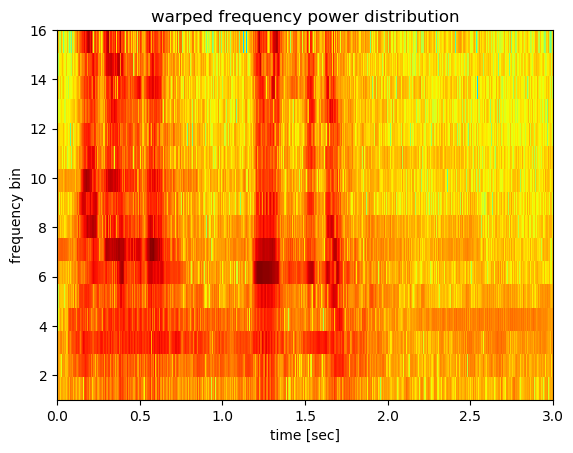

In [6]:
# calculate power of spectral components
mem_spec_pwr = 20*log10.(abs.(mem_spec))'

# plot warped power spectrum
plt.imshow(mem_spec_pwr, aspect="auto", cmap="jet", origin="lower", extent=[t[1], t[end], 1, Int(floor(nr_taps_warped/2))]), plt.xlabel("time [sec]"), plt.ylabel("frequency bin"), plt.title("warped frequency power distribution")
;

## Generative model

In [7]:
# create factor graphs
fg = FactorGraph()

# AR node
@RV γ ~ ForneyLab.Gamma(placeholder(:a_γ), placeholder(:b_γ))
@RV θ ~ GaussianMeanPrecision(placeholder(:μ_θ, dims=(AR_order,)), placeholder(:Λ_θ, dims=(AR_order, AR_order)))
@RV Sprev ~ GaussianMeanPrecision(placeholder(:μ_Sprev, dims=(AR_order,)), placeholder(:Λ_Sprev, dims=(AR_order, AR_order)))
@RV S ~ LAR.AR.Autoregressive(θ, Sprev, γ)

# selection and input
d = zeros(AR_order)
d[1] = 1
@RV x ~ DotProduct(d, S)
@RV v ~ GaussianMeanPrecision(0, Λ_meas)
@RV y = x + v
placeholder(y, :y)

ForneyLab.draw(fg)

<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.38.0 (20140413.2041)
 -->
<!-- Title: G Pages: 1 -->
 
 
 G 
 
<!-- 8945402509806043951 -->
 8945402509806043951 
 
 placeholder_b_γ 
 
<!-- 17144533093223931213 -->
 17144533093223931213 
 
 placeholder_μ_Sprev 
 
<!-- 4320029634050883470 -->
 4320029634050883470 
 
 𝒩 
 gaussianmeanprecision_3 
 
<!-- 4666051350973921612 -->
 4666051350973921612 
 
 clamp_3 
 
<!-- 4320029634050883470--4666051350973921612 -->
 4320029634050883470--4666051350973921612 
 
 clamp_3 
 1 out 
 3 w 
 
<!-- 13680101769944294700 -->
 13680101769944294700 
 
 clamp_2 
 
<!-- 4320029634050883470--13680101769944294700 -->
 4320029634050883470--13680101769944294700 
 
 clamp_2 
 1 out 
 2 m 
 
<!-- 8969128713394379331 -->
 8969128713394379331 
 
 placeholder_Λ_Sprev 
 
<!-- 16233475919618899977 -->
 16233475919618899977 
 
 AR 
 autoregressive_1 
 
<!-- 3253808364979694460 -->
 3253808364979694460 
 
 Gam 
 gamma_1 
 
<!-- 16233475919618899977--3253808364979694460 -->
 16233475919618899977--3253808364979694460 
 
 γ 
 1 out 
 4 γ 
 
<!-- 5932809660760141937 -->
 5932809660760141937 
 
 𝒩 
 gaussianmeanprecision_1 
 
<!-- 16233475919618899977--5932809660760141937 -->
 16233475919618899977--5932809660760141937 
 
 θ 
 1 out 
 3 θ 
 
<!-- 14064670090162003587 -->
 14064670090162003587 
 
 𝒩 
 gaussianmeanprecision_2 
 
<!-- 16233475919618899977--14064670090162003587 -->
 16233475919618899977--14064670090162003587 
 
 Sprev 
 1 out 
 2 x 
 
<!-- 3253808364979694460--8945402509806043951 -->
 3253808364979694460--8945402509806043951 
 
 b_γ 
 1 out 
 3 b 
 
<!-- 11417487857973340040 -->
 11417487857973340040 
 
 placeholder_a_γ 
 
<!-- 3253808364979694460--11417487857973340040 -->
 3253808364979694460--11417487857973340040 
 
 a_γ 
 1 out 
 2 a 
 
<!-- 15286079273727328138 -->
 15286079273727328138 
 
 placeholder_Λ_θ 
 
<!-- 5932809660760141937--15286079273727328138 -->
 5932809660760141937--15286079273727328138 
 
 Λ_θ 
 1 out 
 3 w 
 
<!-- 4005501985899811203 -->
 4005501985899811203 
 
 placeholder_μ_θ 
 
<!-- 5932809660760141937--4005501985899811203 -->
 5932809660760141937--4005501985899811203 
 
 μ_θ 
 1 out 
 2 m 
 
<!-- 1174666221764266491 -->
 1174666221764266491 
 
 clamp_1 
 
<!-- 5153836681826688657 -->
 5153836681826688657 
 
 placeholder_y 
 
<!-- 1633770198954211892 -->
 1633770198954211892 
 
 + 
 addition_1 
 
<!-- 5153836681826688657--1633770198954211892 -->
 5153836681826688657--1633770198954211892 
 
 y 
 1 out 
 1 out 
 
<!-- 14064670090162003587--17144533093223931213 -->
 14064670090162003587--17144533093223931213 
 
 μ_Sprev 
 1 out 
 2 m 
 
<!-- 14064670090162003587--8969128713394379331 -->
 14064670090162003587--8969128713394379331 
 
 Λ_Sprev 
 1 out 
 3 w 
 
<!-- 1633770198954211892--4320029634050883470 -->
 1633770198954211892--4320029634050883470 
 
 v 
 1 out 
 3 in2 
 
<!-- 820294467798041168 -->
 820294467798041168 
 
 dot 
 dotproduct_1 
 
<!-- 1633770198954211892--820294467798041168 -->
 1633770198954211892--820294467798041168 
 
 x 
 1 out 
 2 in1 
 
<!-- 820294467798041168--16233475919618899977 -->
 820294467798041168--16233475919618899977 
 
 S 
 1 y 
 3 in2 
 
<!-- 820294467798041168--1174666221764266491 -->
 820294467798041168--1174666221764266491 
 
 clamp_1 
 1 out 
 2 in1

In [8]:
# specify recognition factorization and create algorithm
q = RecognitionFactorization(S, Sprev, ids=[:S :Sprev])
algo = compatibility_fix(variationalAlgorithm(q))

# evaluate algorith 
eval(Meta.parse(algo))
;

## Load parameters

In [9]:
# placeholder for parameters
params = Array{Dict{String, Union{Array{Float64}, Float64}}, 1}(undef, size(mem_spec_all)[2])

# load parameters
for k = 1:size(mem_spec_all)[2]
    if k <= size(mem_spec_all)[2]/2
        
        # load parameters of real coefficients
        params[k] = h5read(load_file, "bin_real_"*string(k, pad=2))     
        
    else
        
        # load parameters of imaginary coefficients
        params[k] = h5read(load_file, "bin_imag_"*string(k-Int(size(mem_spec_all)[2]/2), pad=2))     

    end
end
;

## Perform inference

In [10]:
# create placeholders for current values
current_μ_Sprev = Array{Array{Float64, 1}, 1}(undef, size(mem_spec_all)[2])
current_Λ_Sprev = Array{Array{Float64, 2}, 1}(undef, size(mem_spec_all)[2])

# initialize marginals and data dictionaries
marginals = Array{Dict{Symbol, ProbabilityDistribution}, 1}(undef, size(mem_spec_all)[2])
data = Array{Dict{Symbol, Union{Array{Float64}, Float64}}, 1}(undef, size(mem_spec_all)[2])

# initialize priors
for k = 1:size(mem_spec_all)[2]
    
    # randomly initialize uninformative priors
    current_μ_Sprev[k] = randn(AR_order)
    current_Λ_Sprev[k] = tiny*diagm(randn(AR_order))
    
    # fill marginals/data with empty dictionary
    marginals[k] = Dict()
    data[k] = Dict()
    
end


# placeholder for spectral estimates
μ_s_pred = Array{Array{Float64,1}}(undef, size(mem_spec_all)[1])
Λ_s_pred = Array{Array{Float64,1}}(undef, size(mem_spec_all)[1])
for sp = 1:size(mem_spec_all)[1]
    μ_s_pred[sp] = Array{Float64, 1}(undef, size(mem_spec_all)[2])
    Λ_s_pred[sp] = Array{Float64, 1}(undef, size(mem_spec_all)[2])
end

# create progress bar
p = Progress(size(mem_spec_all)[1], 1, "Observed ")

# loop through signal samples
for sp in 1:size(mem_spec_all)[1]
    
    # update progress bar
    update!(p, sp)
    
    # loop through components
    for bin in 1:size(mem_spec_all)[2]
    
        # update marginals
        marginals[bin][:θ] = ProbabilityDistribution(ForneyLab.Multivariate, GaussianMeanPrecision, m=params[bin]["theta_mean"], w=params[bin]["theta_precision"])
        marginals[bin][:γ] = ProbabilityDistribution(ForneyLab.Univariate, ForneyLab.Gamma, a=params[bin]["gamma_a"], b=params[bin]["gamma_b"])
        marginals[bin][:Sprev] = ProbabilityDistribution(ForneyLab.Multivariate, GaussianMeanPrecision, m=current_μ_Sprev[bin], w=current_Λ_Sprev[bin])
        
        # perform variational message passing iterations
        for it = 1:iterations
            
            # update data dictionary   
            data[bin] = Dict(:y => mem_spec_all[sp, bin],
                             :μ_Sprev => current_μ_Sprev[bin],
                             :Λ_Sprev => current_Λ_Sprev[bin])      
        
            # perform inference
            data[bin], marginals[bin] = step_all!(data[bin], marginals[bin])
            
            # update current parameters
            current_μ_Sprev[bin] = ForneyLab.unsafeMean(marginals[bin][:Sprev])
            current_Λ_Sprev[bin] = ForneyLab.unsafePrecision(marginals[bin][:Sprev])
            
        end
        
        # update current parameters
        current_μ_Sprev[bin] = ForneyLab.unsafeMean(marginals[bin][:S])
        current_Λ_Sprev[bin] = ForneyLab.unsafePrecision(marginals[bin][:S])
        
        # save marginal of x
        μ_s_pred[sp][bin] = ForneyLab.unsafeMean(marginals[bin][:S])[1]
        Λ_s_pred[sp][bin] = ForneyLab.unsafePrecision(marginals[bin][:S])[1,1]
        
    end
    
end
;

Observed 100%|██████████████████████████████████████████| Time: 0:17:029:54


## Convert noisy and denoised coefficients back to time signal

In [11]:
# convert predictions back to complex coefficients
fourier_coef = Array{Array{Complex{Float64},1},1}(undef, size(mem_spec_all)[1])
time_pred = Array{Array{Float64,1},1}(undef, size(mem_spec_all)[1])
# loop through all predictions
for sp = 1:size(mem_spec_all)[1]
    if nr_taps_warped%2 == 0
        # get real part of coefficients
        coef_real = μ_s_pred[sp][1:Int(length(μ_s_pred[sp])/2)]
        
        # get imaginary part of coefficients
        coef_imag = μ_s_pred[sp][Int(length(μ_s_pred[sp])/2)+1:end]
        
        # determine fourier coefs (DC=0, normal up to length-1, conj of length with order reversed, see fftfreq)
        fourier_coef[sp] = vcat(0, coef_real[1:end-1] .+ 1im*coef_imag[1:end-1], reverse(coef_real) .- 1im*reverse(coef_imag))

    else
        # to do
    end
end

# convert back to time domain (discard imaginary part, because of expected complex conjugacy)
for sp = 1:size(mem_spec_all)[1]
    time_pred[sp] = real.(FFTW.ifft(fourier_coef[sp]))
end

In [12]:
# convert noisy coefficients back to complex coefficients
fourier_coef_noisy = Array{Array{Complex{Float64},1},1}(undef, size(mem_spec_all)[1])
time_pred_noisy = Array{Array{Float64,1},1}(undef, size(mem_spec_all)[1])
# loop through all predictions
for sp = 1:size(mem_spec_all)[1]
    if nr_taps_warped%2 == 0
        # get real part of coefficients
        coef_real = mem_spec_all[sp, 1:Int(length(mem_spec_all[sp,:])/2)]
        
        # get imaginary part of coefficients
        coef_imag = mem_spec_all[sp, Int(length(mem_spec_all[sp,:])/2)+1:end]
        
        # determine fourier coefs (DC=0, normal up to length-1, conj of length with order reversed, see fftfreq)
        fourier_coef_noisy[sp] = vcat(0, coef_real[1:end-1] .+ 1im*coef_imag[1:end-1], reverse(coef_real) .- 1im*reverse(coef_imag))

    else
        # to do
    end
end

# convert back to time domain (discard imaginary part, because of expected complex conjugacy)
for sp = 1:size(mem_spec_all)[1]
    time_pred_noisy[sp] = real.(FFTW.ifft(fourier_coef_noisy[sp]))
end

## Fetch expected input/output of warped filter bank and visualize

<source src="data:audio/wav;base64,UklGRqDeAgBXQVZFZm10ICgAAAD+/wEAgD4AAAD6AAAEACAAFgAgAAAAAAADAAAAAAAQAIAAAKoAOJtxZGF0YWTeAgBybE07tSD9OwdxHDyRQSo8GWwVPIyeBzx2Hgc8SWr2O4Q4qTua68Y6UytxOkdKMDtRLCc7229rO40mjTpGmLo6ybmAuixZ+7sZ9l28vNCivJwizrzD4QO9k8opvXLeSb08Olu9GUd3vXsMhb07L5C9RCWVvdAKlb31K5K9Eg2QvT/thL3B2mK9AOE0vaFtAb2W5Jm8NxyEu5eQDTw546Y8SiPaPHsj8zxvWwE94bkKPUa9Fz1UqzU9ESJGPdsUaD2AkoQ9RxeQPZm/mD2ku6A9W4OuPfbDtD0AHr09ahfAPXCnwz1RTsY9fWjRPcmt0z1oBs89aUrIPTqawD1lKrM9H+ihPV+UkT0GA4U9sVhlPcTGRz15Ki49Z9IMPfru1zxI4ps80zslPPb4lztrz/I6+UqYuHKo8bp0VHS7SNyTu5CkyLuv1BO8ewZYvImZr7xG8gC9Qf8pvThAUr11l229Y1d7vSL+i73Dj5a9ZCGevZRopL2izay9SgmyvXNQtr1hrLO98heuvXE/n73hTpC9SO13vemrQ73frhy9Nrj4vFqdt7yOSIO8Uds+vFt39rvK7Hi7TSA5OuHJFTsAT6I7VrwFPOfuITxyHF48+MuQPBXypDzX86o8sX7EPNEv4jzF7/Q8okPwPEHLAT0h8gI9tUgDPQeeBT1fXwo9Q7ESPUEwGT1awyE9jm0mPYzNIj0NZx89NC4TPckj+zzcedw8ZsaxPM2FnTz/XIo8NSdSPKEs4TutcBU6XHDSuwVvP7zyQoa8u7i/vI/h+LzVQim9cIpOvUMweb2Ue429tKefvW5SsL3/+rq9jFq9vUEHvr1fabm9Nk23vXcosb2wx6K9tF2PvffUar1GTS+9Po3bvNZMNLx4Ndw7aRSYPI9+AD15QiI9p25APeQDXD35gHc94k2DPXU2gz3rB4I9CTZ8PRrydD3fdF899MVXPTn1Rz2lhDY9yUEiPcjhEz3Nfgw9D+MVPU8/Gj1RtSI9KjAUPTDSAj0fwvY8A5jZPKjbyDxpKZc8qxKEPJHwbzyugV88QZhAPADpKjySxXQ7NfuCuwNoDryNq3S8giCyvG/95rzZE/q8qvQAvYPqFb3Iphi9sTYTvceVBr0c6wG91ooLvbABEL0WSRi9idggvd8wIb3I2SG9DxgqvTtzJL1vdCS9uTAmvc1CI72l3yK9LOYWvTqk8LwWg7C8vbkuvD5g1Tq4Nos8S74APcwGLT0va1g9NL15PSt+hz02zoo9L+CNPQVmjT1NVYc9aMBzPSRTXj0fQ0s9/vM+PVN9Rj1xt0s92RZJPb5qRD3Oxjw9tWk2PbTHIz2NSAo97eT0PBOW2Twk7L08DmybPI2jiTxQG1g8rlAhPN1drzrouAa8aN+ZvMwq37wd3ge9i9YgvVlZPL0LLVi9enJnvcKKdb036IG9O4SPvdg6mb0JDqC9CXKhvSicnr0vfJy9rkefvQsmob0N76W9T92yvca1wr1BPNK9vn/dvT5q772KL/m98hoBvhzpAL6asf291cb0vQLQ6r3tYdy93xDHvWq5sL2RDpa9sbh0vR3qKr1ny9e81GUZvABcTDspKWA8sS6nPOBm1DxVL/w87SwKPTPaBz29hQo9hq8IPX4sAj0eBgI9LGD2PJt/2DwAI7s8mVCpPOIgmzyP+Hs8JWlLPCLJUjx3+lo8YJhqPFH4nTyxub88qSTRPHj23TybieA88KDdPHT76Dw92f08ww4EPVHKDT27pg89xf4IPb2z9zwUjso8QtagPFX5TzxXfBE8yYWROxNRCzsSGuQ6i+XFOrwQGjsn92I7CHu5O/ywkjupTXM7YTAROaRbFbvFeIC7WlDJu2ggMbwBcHG8KKKpvF6Kzrw56e68cwz6vJVz/Lzwg9e820mpvMJgbryv/8G7JKyLOQCLzTsEs2s8YjSvPFCs1TwewfA8QzEMPRzFFz07uhE9YBIOPQMx9jwGIMg8fYuYPLpnbDwL1j48JYNCPKw0XDwvjnE83Vh2PP4rVzxNxjY8pKcMPFjEqTvvuY46xEL7upOJCLxbmEG8N8xvvIzCj7yQIbK8f4fFvBGXsbx918W8VsXxvFsqAL37lAK9TEEDvQ/f+bx5n9i86SHIvHaRx7yvCrS8UEKGvDKPTbxiOfS7E1E+uwZkQDv4Oz88YKmlPJZO+TwxIBo9FHwwPeO6TD0xllg9B3hhPXoKXj34zVc9S2BYPWdRXj0op2c92I53PV79gT2KlYo9Q+ibPSu2qj2DKLg9N4zCPdrvxD0J1MY91YDHPe2Mvz3DQro9sB2rPfuBoD2fWJA9sZB7PT1iWz3VvTM9odAMPR0TxDwZLXE8bgktOyFdKrwujdS8rQwYvRdHQ70BtW69gkyTvX79rb0/n8a9IS7jvXUB/b2yLAe+/3EMvrclEL46fQ++owkSvmXwE77ORhW+LYETvlbkEb6pCw6+I2EHvtXkAL6O/fW93I7evbMdxr0Yt7O9UdGavbXHgr0Iz2i9nYtUvVp1TL2CHzC9aZ0WvdqHDL0upu68wFywvC/Hc7yyR+q7fVoLukZitjuBMRI8UdVkPIGipTx5Z8g8qwcIPd/vNj0TLmM9vIGPPcJMqT1KdsE9Gb7YPYhb7T10R/09wgkDPvb6Aj6u1AQ+EVgDPrl2+T3hh+o9hsDbPYj5zj16Cr495sKpPe9+kz2JZng9Ld4/PVMrFj07FKk8OuinOysRg7uglZS8sn/ivNeJIL3Ou1K9ZMt5vYb9i72yBpO9YFqZvZa2nL3xSKO9A4mlvRkwor0dcZu9rxCQvUZxhL0s+mq9JF9cvcavSb3FLze9zkAXvaX//byjO8C8qJFxvHFD8rtCDGU7cPFNPLovmzyEVro84GHbPOhnBD2swx09zvIpPY3xOD385FE9salcPZSQXD0Lq249nVlpPcCSZz3t6F89a15WPd7haD2Zn2c9jFuCPcnWjj2mGJk9axOlPSYwrD17q6s9Z+OoPRGLoj3P8pE9pdF3PdaLLz3cjMU82LkMPFXsmLuEwDG8sGGOvCR94Lx6EO+8B4wRva3UHb1tkzO90UBOvQZLbr2HHHa9uOV5vRrPd73aoG296SRcvRtsOL35ry+9CgorveMEM728IUS9rJ9SvfZMXb0fgWq9pzBuvTvccL3n5269lV1wvbgNdr0Xy2q9GmdnvZbHab3M23C99ztxvYoZa7270FG9NtE0vaWzGL3OZPe8wxq3vFCuLLyihMu7A8GbO7yMubonLRa8RRmaO1UunDqox5S8uWVkvGcHuLsblcq7TWx5OxZtiDyLmdQ8uT0TPWTYOD1zK0g9GrhSPQ8aTD2H6z49FTs6PVCBGT3zMOk8sWDsPDJc5zxktsE8DwHJPDiIxjxQWKw8rCKkPE/0mzzHm5s8KU+mPIf6rjyaMds8XTsFPeizDD30KDY9gcNEPY5NMj081UI9x1ZlPQXPXz1jZj09g204PYCPGD22vds8u6+bPD9dLboz6rO8p7kGvQcvNr24qYC9q6usvbKv0b1os8+9qlivvVvtp72VD5m9iiZtvbW7F717xWG84weAu4CTc7mKMnE7EUlGPAQbwjzZ6O48OVP8PGOUBD0+zBs9WWsPPaKTAT3xB6E8jF0HPN5hLbtVxjG9sHJJvZIgOr2uf6S921HbvYVQ1L2eROW9HVAIvmJTB76NfAO+cDwWvgxUIr5tRR6+DfMXvitBFr4/ug2+S+z3vfcH073W0bW9GQ+Vva1Adb3wgD69n2QWvfnnBL07GPO80E21vMELlLzD+Ye8mYowvDm3e7tk5Qw7AxpaPKLPoDyoE8I81FHuPB0nDD0c6jg90aVPPaySbD1JBY090m+lPa6bvT2wXdY9HMDcPd8e+j3Kr

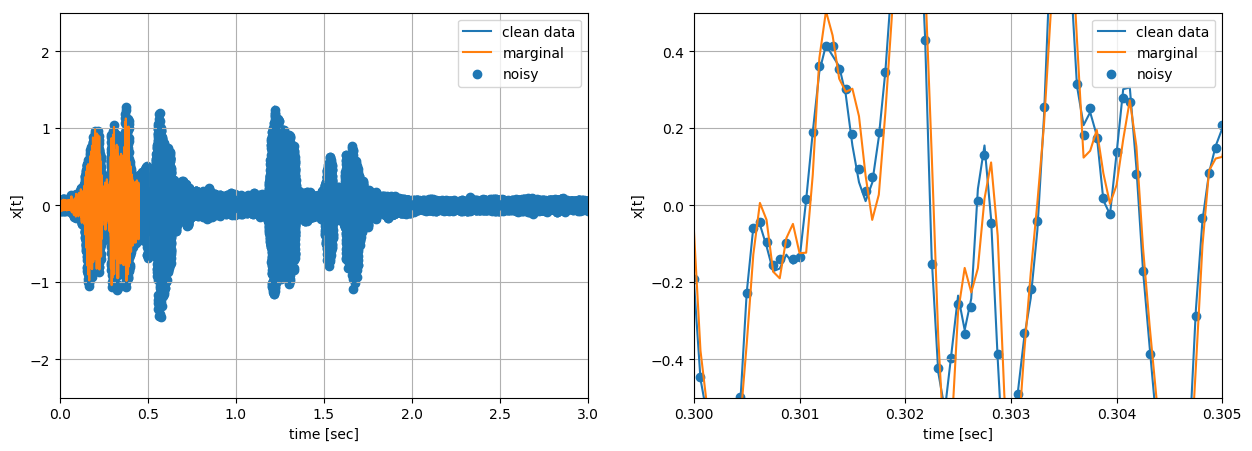

In [18]:
# get predicted input and output samples
true_signal = [mem_taps[k][1] for k=1:size(mem_spec_all)[1]]
noisy_signal = [time_pred_noisy[k][1] for k = 1:size(mem_spec_all)[1]]
denoised_signal = [time_pred[k][1] for k = 1:size(mem_spec_all)[1]]

# create figure
_, ax = plt.subplots(ncols=2, figsize=(15,5))

# plot actual, noisy and marginal of frequency component
ax[1].plot(t, true_signal, label="clean data"), ax[1].scatter(t, noisy_signal, label="noisy"), ax[1].plot(t, denoised_signal, label="marginal")
ax[2].plot(t, true_signal, label="clean data"), ax[2].scatter(t, noisy_signal, label="noisy"), ax[2].plot(t, denoised_signal, label="marginal")

# change vizualization
ax[1].grid(), ax[1].set_xlim(0,3), ax[1].set_ylim(-2.5, 2.5), ax[1].set_xlabel("time [sec]"), ax[1].set_ylabel("x[t]"), ax[1].legend()
ax[2].grid(), ax[2].set_xlim(0.3,0.305), ax[2].set_ylim(-0.5, 0.5), ax[2].set_xlabel("time [sec]"), ax[2].set_ylabel("x[t]"), ax[2].legend()

# create audioplayers (remove first ~1000 to save your ears) {true, noisy, denoised}
from = 1000
audioplayers(true_signal[from:end], noisy_signal[from:end], denoised_signal[from:end], fs=fs_desired)
;